In [1]:
from pymatreader import read_mat
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import feather

In [4]:
data = read_mat('B0005.mat')
df = pd.DataFrame(data['B0005'])
display(df)

def to_sec(vec):
    day, hr, min, sec = vec[2:]
    return (day*86400 + hr*3600 + min*60 + sec)

times = []
for i in df['cycle']['time']:
    times.append(to_sec(i))

times = np.array(times) - times[0]
print(times[-3:])
del_times = [times[i+1] - times[i] for i in range(len(times)-1)]
print(times[-3:], del_times[-3:])
df['cycle'][2] = del_times
df['cycle'][3] = df['cycle'][3][:-1]

sep_indices = {'impedance': [], 'charge': [], 'discharge': []}
for i in range(len(df['cycle'][3])):
    for j in ['discharge', 'charge', 'impedance']:
        if df['cycle'][3][i] == j: sep_indices[j].append(i)

display(df)

,cycle
ambient_temperature,"[24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 2..."
data,"[{'Voltage_measured': [3.873017221300996, 3.47..."
time,"[[2008.0, 4.0, 2.0, 13.0, 8.0, 17.921], [2008...."
type,"[charge, discharge, charge, discharge, charge,..."


[2187444.204 2190370.719 2239284.125]
[2187444.204 2190370.719 2239284.125] [10302.35999999987, 2926.5150000001304, 48913.40599999996]


,cycle
ambient_temperature,"[24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 2..."
data,"[{'Voltage_measured': [3.873017221300996, 3.47..."
time,"[8243.671999999991, 4330.391000000003, 11156.4..."
type,"[charge, discharge, charge, discharge, charge,..."


In [7]:
def get_from_indices(row, type):
    row_data = df['cycle'][row]
    req_data = []
    for i in sep_indices[type]: 
        req_data.append(row_data[i])

    return req_data

def df_subpart(type):
    df_info = {'temp': get_from_indices(0,type), 
               'data': get_from_indices(1,type), 
               'time': get_from_indices(2,type)}
    '''m = 0
    for i in list_dicts[0].keys():
        df_info[i] = list_dicts[m][i]
        m += 1'''

    return pd.DataFrame.from_dict(df_info)

In [21]:
df_ch = df_subpart('discharge')
display(df_ch.head())

datapoint = 24
plt.figure(figsize=(10,10))
m = 0
for i in df_ch['data'][datapoint].keys(): 
    plt.subplot(321+m)
    plt.plot(df_ch['data'][datapoint][i])
    plt.title(i + f": {len(df_ch['data'][datapoint][i])} points")
    m += 1 
plt.show()

,temp,data,time
0,24,"{'Voltage_measured': [4.191491807505295, 4.190...",4330.391
1,24,"{'Voltage_measured': [4.189773213846608, 4.188...",4312.406
2,24,"{'Voltage_measured': [4.188186735991303, 4.187...",4291.984
3,24,"{'Voltage_measured': [4.188461118855572, 4.187...",4271.750
4,24,"{'Voltage_measured': [4.188298524761055, 4.187...",4269.375


IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

<Figure size 720x720 with 0 Axes>

In [18]:
df_ch['data'][0]['Capacity']

1.8564874208181574

In [22]:
cap = []
for i in range(len(df_ch)): cap.append((df_ch['data'][i]['Capacity']))

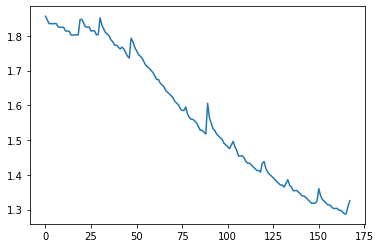

In [25]:
plt.plot(cap)

In [28]:
from statsmodels.tsa.arima.model import ARIMA
from random import random
# contrived dataset
data = [x + random() for x in range(1, 100)]
# fit model
model = ARIMA(data, order=(0, 0, 1))
model_fit = model.fit()
# make prediction
yhat = model_fit.predict(len(data), len(data))
print(yhat)

C:\Users\bhavy\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


[74.89444204]


In [46]:
# HWES example
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from random import random
# contrived dataset
data = [x + random() for x in range(1, 100)]
# fit model
model = ExponentialSmoothing(data)
model_fit = model.fit()
# make prediction
yhat = model_fit.predict(len(data), len(data))
print(yhat)

[99.19975795]


C:\Users\bhavy\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


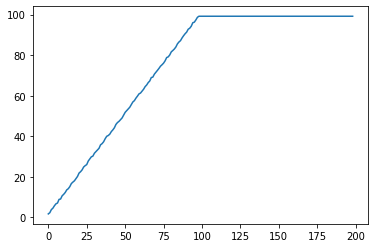

In [56]:
preds = [i for i in data]
for i in range(100): 
    preds.append(model_fit.predict(len(data), len(data)))
plt.plot(preds)

In [ ]:

from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib import pyplot
# load dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
# split data into train and test
X = series.values
train, test = X[0:-12], X[-12:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# make prediction
	predictions.append(history[-1])
	# observation
	history.append(test[i])
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(test)
pyplot.plot(predictions)
pyplot.show()